In [1]:
import torch

# Dataset

In [2]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [3]:
hr = pd.read_csv('../data/fitbit_apr/heartrate_seconds_merged.csv')

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, csv_path, value_col='Value', time_col='Time', 
                 interval_value=5, interval_unit='s', interpolation_limit=11,
                 kernel_size=512, stride=256, missing_thresh=0.5):
        self.data = pd.read_csv(csv_path)
        self.value_col = value_col
        self.time_col = time_col
        self.data = self.construct_dataset(interval_value, interval_unit, interpolation_limit)

        self.seqs = []
        self.masks = []
        self.create_seq(kernel_size, stride, missing_thresh)

    def construct_dataset(self, interval_value, interval_unit, interpolation_limit):
        '''Reindexes data using pd.date_range with a frequency of interval_value interval_unit.
        Interpolates data with a limit of interpolation_limit'''
        self.data[self.time_col] = pd.to_datetime(self.data[self.time_col])
        dfs = []
        for id, group_data in self.data.groupby('Id'):
            group_data = group_data.set_index(self.time_col)
            
            # Create time index with interval
            min_time = group_data.index.min()
            max_time = group_data.index.max()
            new_time_index = pd.date_range(min_time, max_time, freq=str(interval_value)+interval_unit)

            # Reindex with new time index
            reindex_group = group_data.reindex(new_time_index, method='nearest', tolerance=pd.Timedelta(interval_value-1, unit=interval_unit))

            # Reset index and add back ID column
            reindex_group.reset_index(inplace=True)
            reindex_group.rename(columns={'index': self.time_col}, inplace=True)
            reindex_group['Id'] = id
            
            dfs.append(reindex_group)

        return pd.concat(dfs).reset_index(drop=True).interpolate(limit=interpolation_limit)
    
    def create_seq(self, kernel_size, stride, missing_thresh):
        for id, group_data in self.data.groupby('Id'):
            data_len = len(group_data)
            for i in range(0, data_len, stride):
                seq = group_data.Value[i:i+kernel_size]
                if seq.isna().mean() <= missing_thresh:
                    self.seqs.append(np.array(seq))
                    self.masks.append(np.array(seq.notna()))

    def __len__(self):
        return len(self.seqs)
    
    def __getitem__(self, idx):
        seq = torch.tensor(self.seqs[idx], dtype=torch.float32)
        return seq, self.masks[idx]

In [5]:
dataset = TimeSeriesDataset('../data/fitbit_apr/heartrate_seconds_merged.csv')

# Model

In [6]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={"task_name": "reconstruction"},  # For anomaly detection, we will load MOMENT in `reconstruction` mode
    local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

c:\Users\user\Desktop\Sputnik\2023-\CS50\health-app\env\Lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\user\Desktop\Sputnik\2023-\CS50\health-app\env\Lib\site-packages\huggingface_hub\hub_mixin.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

In [7]:
model

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

In [8]:
dataloader = DataLoader(dataset, batch_size=1)
x, mask = next(iter(dataloader))
x, mask

(tensor([[ 97.0000, 102.0000, 105.0000, 104.0000, 103.0000, 101.0000, 100.2500,
           99.5000,  98.7500,  98.0000,  97.2500,  96.5000,  95.7500,  95.0000,
           91.0000,  93.0000,  94.0000,  93.0000,  92.5000,  92.0000,  89.0000,
           86.0000,  83.0000,  61.0000,  60.0000,  60.5000,  61.0000,  61.0000,
           61.0000,  61.0000,  57.0000,  55.5000,  54.0000,  54.5000,  55.0000,
           56.5000,  58.0000,  59.0000,  60.0000,  59.5000,  59.0000,  58.0000,
           57.0000,  56.5000,  56.0000,  57.0000,  58.0000,  57.6667,  57.3333,
           57.0000,  58.0000,  60.0000,  60.0000,  59.3333,  58.6667,  58.0000,
           57.0000,  55.0000,  54.0000,  52.0000,  53.0000,  53.0000,  53.0000,
           53.0000,  53.0000,  53.5000,  54.0000,  53.5000,  53.0000,  53.0000,
           53.0000,  53.0000,  53.0000,  53.0000,  53.0000,  53.0000,  53.5000,
           54.0000,  55.0000,  55.3333,  55.6667,  56.0000,  57.0000,  58.0000,
           60.0000,  62.0000,  63.0000, 

In [9]:
x = x[None, :, :]
x.shape

torch.Size([1, 1, 512])

In [10]:
with torch.no_grad():
    output = model(x_enc=x, input_mask=mask)

In [11]:
pred = output.reconstruction.squeeze().numpy()
true = x.squeeze().numpy()
anomaly_score = (true - pred)**2

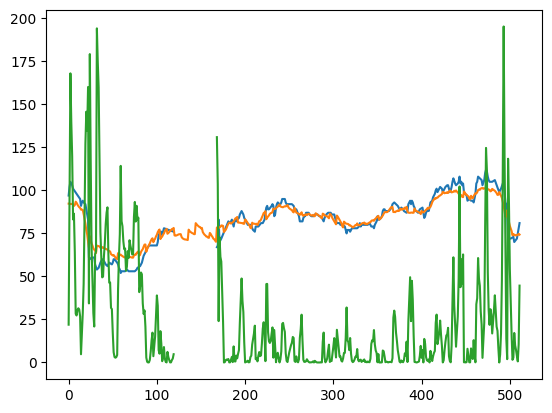

In [12]:
import matplotlib.pyplot as plt

plt.plot(true)
plt.plot(pred)
plt.plot(anomaly_score)